In [8]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow import keras 
from tensorflow.keras import layers
import os
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense, BatchNormalization, AveragePooling2D, Flatten
from sklearn import svm 
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
import aspose.words as aw

In [12]:
'''Convert all images to PNG -- run only one time'''

def save_images_as_png(folder_path, output_folder, image_size=(150, 150)):
    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            file_path = os.path.join(root, filename)
            if any(filename.endswith(extension) for extension in ['.jpg', '.jpeg', '.png', '.gif']):
                try:
                    with Image.open(file_path) as img:
                        # Create the output folder structure if it doesn't exist
                        relative_path = os.path.relpath(root, folder_path)
                        output_subfolder = os.path.join(output_folder, relative_path)
                        os.makedirs(output_subfolder, exist_ok=True)
                        # Convert and save the image as PNG
                        if img.mode == 'CMYK':
                            img = img.convert('RGB')
                        output_file_path = os.path.join(output_subfolder, filename.split('.')[0] + '.png')
                        img = img.resize(image_size)  # resizing image
                        #img = img.convert('L')  # Converting to grayscale
                        img.save(output_file_path, format='PNG')
                except Exception as e:
                    print(f"Error processing image '{file_path}': {e}")

folder_path = r"C:\Users\emili\OneDrive\Dokumente\03_Master_CBS\05_Summerterm24\01_ML and DL\Project\logo findder"
output_folder=r"C:\Users\emili\OneDrive\Dokumente\03_Master_CBS\05_Summerterm24\01_ML and DL\Project\png logo findder"
save_images_as_png(folder_path, output_folder)

In [16]:
"""Getting df with all filenames and images (missing labels at this stage) - shape = (166866,2)"""
# only take first ten photos in each brand folder
# (150,150) grayscale --> 2m 28.9s
# (150,150) rgb, with pixels as cols --> 

def load_images_from_folder(folder_path, image_size=(150, 150)):
    images = []
    
    # Recursively traverse through the folder structure
    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            # Get the full path of the file
            file_path = os.path.join(root, filename)
            
            # Check if the file is an image
            if any(filename.endswith(extension) for extension in ['.jpg', '.jpeg', '.png', '.gif']):
                # Load the image using PIL (Python Imaging Library)
                try:
                    with Image.open(file_path) as img:
                        img = img.resize(image_size) #resizing image
                        img = img.convert('RGB') #Converting to gray scale
                        #img_array = np.array(img) / 255.0 # Convert the image to numpy array and normalize pixel values
                         # Extract folder name from the root path
                        label = os.path.basename(root)
                        
                        images.append({'Label': label, 'Filename': filename, 'Image': img})
                        #images.append({'Filename': filename, 'Image': img}) # Append the image array to the list
                except Exception as e:
                    print(f"Error loading image '{file_path}': {e}")
    
    # Convert the list of dictionaries to a DataFrame
    images_df = pd.DataFrame(images)
    return images_df

# Loading
png_folder_path=r"C:\Users\emili\OneDrive\Dokumente\03_Master_CBS\05_Summerterm24\01_ML and DL\Project\png logo findder"
image_df = load_images_from_folder(png_folder_path)
print('Image Dataframe: \n \n', image_df.head())

Error loading image 'C:\Users\emili\OneDrive\Dokumente\03_Master_CBS\05_Summerterm24\01_ML and DL\Project\png logo findder\Original Aston Martin logo\Image_30.png': Decompressed Data Too Large
Error loading image 'C:\Users\emili\OneDrive\Dokumente\03_Master_CBS\05_Summerterm24\01_ML and DL\Project\png logo findder\Original Maserati logo\Image_13.png': Decompressed Data Too Large
Error loading image 'C:\Users\emili\OneDrive\Dokumente\03_Master_CBS\05_Summerterm24\01_ML and DL\Project\png logo findder\Original Porsche logo\Image_18.png': Decompressed Data Too Large
Image Dataframe: 
 
                         Label      Filename  \
0  Original Aston Martin logo  Image_10.png   
1  Original Aston Martin logo  Image_11.png   
2  Original Aston Martin logo  Image_12.png   
3  Original Aston Martin logo  Image_13.png   
4  Original Aston Martin logo  Image_15.png   

                                               Image  
0  <PIL.Image.Image image mode=RGBA size=150x150 ...  
1  <PIL.Image.Im

In [17]:
"""Run to get an overview of the data"""

#Get an overview of the number of images per label
labelinfo = image_df['Label'].value_counts() 
print('About the Distribtion of Labels:')
print('The number of different brands is', len(labelinfo))
print('The number of images per brand ranges from',labelinfo.min(),'to', labelinfo.max())
print('The average is',labelinfo.mean().round(),'and the median is', labelinfo.median())

#Get an overivew of image characteristics (size, channels) in the dataset
#function to extract image characteristics
def get_image_characteristics(image):
    size = image.size  # Get image size (width, height)
    mode = image.mode  # Get image mode (color mode)
    return size, mode

image_sizes = []
image_modes = []
for index, row in image_df.iterrows():
    size, mode = get_image_characteristics(row['Image'])  # Assuming 'Image' is the column containing PIL images
    image_sizes.append(size)
    image_modes.append(mode)

image_characteristics_df = pd.DataFrame({'Size': image_sizes, 'Mode': image_modes})

#Print an overview of the image characteristics
print('\nAbout the Images in the Dataset:')
print('The number of different sizes is', len(image_characteristics_df['Size'].unique()))
print('Image size(s) in the dataset:', image_characteristics_df['Size'].unique())
print('The number of different color modes is', len(image_characteristics_df['Mode'].unique()))
print('Color mode(s) in the dataset:', image_characteristics_df['Mode'].unique())

#Get an overivew of the first rows of df
print('\n')
print('Quick view of dataframe:')
image_df.head()

About the Distribtion of Labels:
The number of different brands is 14
The number of images per brand ranges from 18 to 29
The average is 26.0 and the median is 27.0

About the Images in the Dataset:
The number of different sizes is 1
Image size(s) in the dataset: [(150, 150)]
The number of different color modes is 1
Color mode(s) in the dataset: ['RGBA']


Quick view of dataframe:


,Label,Filename,Image
0,Original Aston Martin logo,Image_10.png,<PIL.Image.Image image mode=RGBA size=150x150 ...
1,Original Aston Martin logo,Image_11.png,<PIL.Image.Image image mode=RGBA size=150x150 ...
2,Original Aston Martin logo,Image_12.png,<PIL.Image.Image image mode=RGBA size=150x150 ...
3,Original Aston Martin logo,Image_13.png,<PIL.Image.Image image mode=RGBA size=150x150 ...
4,Original Aston Martin logo,Image_15.png,<PIL.Image.Image image mode=RGBA size=150x150 ...


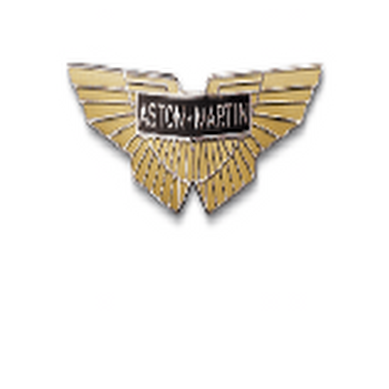

In [19]:
# Selecting one picture from the DataFrame
some_pic = image_df['Image'].iloc[7]

# Display the image using matplotlib
plt.imshow(some_pic, interpolation="lanczos")
plt.axis("off")
plt.show()

In [20]:
label_encoder = LabelEncoder()
image_df['Label coded'] = label_encoder.fit_transform(image_df['Label'])
image_df

,Label,Filename,Image,Label coded
0,Original Aston Martin logo,Image_10.png,<PIL.Image.Image image mode=RGBA size=150x150 ...,0
1,Original Aston Martin logo,Image_11.png,<PIL.Image.Image image mode=RGBA size=150x150 ...,0
2,Original Aston Martin logo,Image_12.png,<PIL.Image.Image image mode=RGBA size=150x150 ...,0
3,Original Aston Martin logo,Image_13.png,<PIL.Image.Image image mode=RGBA size=150x150 ...,0
4,Original Aston Martin logo,Image_15.png,<PIL.Image.Image image mode=RGBA size=150x150 ...,0
...,...,...,...,...
364,Original Porsche logo,Image_5.png,<PIL.Image.Image image mode=RGBA size=150x150 ...,13
365,Original Porsche logo,Image_6.png,<PIL.Image.Image image mode=RGBA size=150x150 ...,13
366,Original Porsche logo,Image_7.png,<PIL.Image.Image image mode=RGBA size=150x150 ...,13
367,Original Porsche logo,Image_8.png,<PIL.Image.Image image mode=RGBA size=150x150 ...,13


In [21]:
image_df['Label coded'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [22]:
#augment the data with tf (more common is to add these layers into the model, but what about SVM then?)
img_size=150

augment = tf.keras.Sequential([
    layers.Resizing(img_size, img_size), #to make size every pic is 150x150 (necessary?)
    layers.RandomFlip(mode='horizontal_and_vertical'), #flipping it
    layers.RandomZoom(0.2),
    layers.RandomRotation(0.1), #randomly rotate it
    layers.Rescaling(1./255) #we aslo rescale it later so maybe not?
])

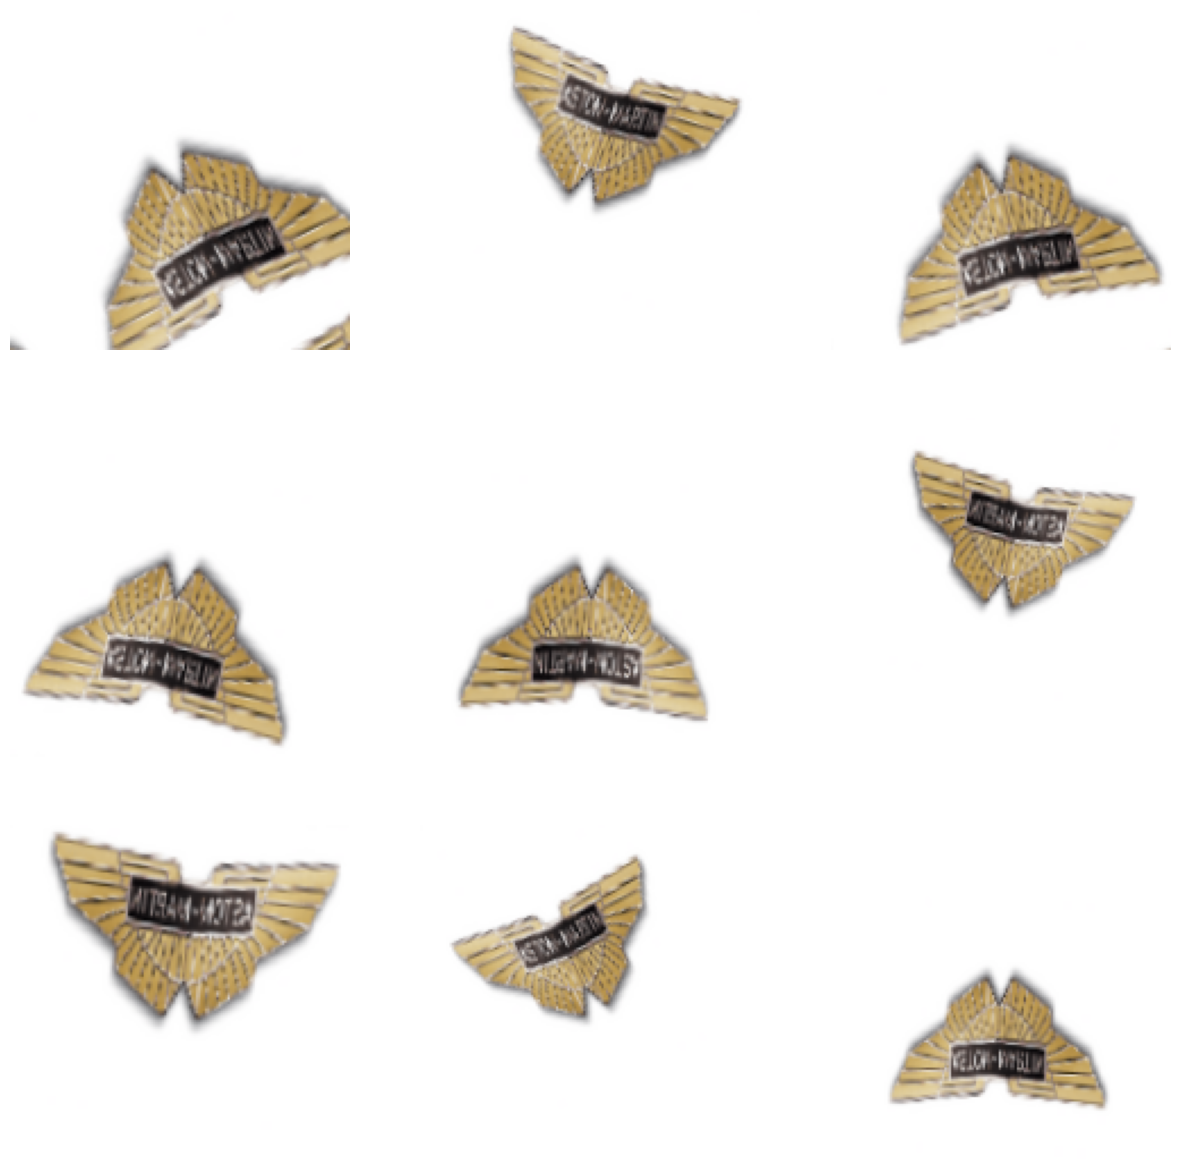

In [23]:
#plot one image
some_pic_tf = tf.cast(tf.expand_dims(some_pic, 0), tf.float32)

plt.figure(figsize=(15, 15))

for i in range(9):
    augmented_image = augment(some_pic_tf)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

## QUESTION: DO WE WANT PIL INPUT OR TENSOR??

In [24]:
'''This function will apply the augmentation mechanisms'''

def apply_aug(img, aug, filename, label_coded, Label, num_aug_images=7): #maybe even more than seven
    img = tf.convert_to_tensor(img)
    img = tf.expand_dims(img, axis=0)
    augmented_img = aug(img)[0] 
    augmented_images = [augmented_img for _ in range(num_aug_images)]
    
    # Convert the augmented images to PIL Image objects if needed
    #augmented_images = [Image.fromarray((augmented_img.numpy() * 255).astype('uint8')) for augmented_img in augmented_images]
    
    # Create a DataFrame to store the augmented images
    data = {'Filename': [filename] * len(augmented_images), 'Label coded': [label_coded] * len(augmented_images), 'Label': [Label]* len(augmented_images),'Augmented_Image': augmented_images}
    df = pd.DataFrame(data)
    
    return df

def augment_images(df, coded, label, name, image):
    '''This function actually applies the augmentation to images in the DataFrame'''
    dataframes = []  #Creating a list to store the augmented images

    for index, row in df.iterrows(): #Loop through each row in the data frame
        label_coded = row[coded]
        Label = row[label]
        filename = row[name]
        
        #Find the original image in the input data frame 
        original_image_row = df[df[name] == filename].iloc[0]
        original_image = original_image_row[image]
        
        #Apply augmentation of the previous function to the original image
        augmented_images_df = apply_aug(original_image, augment, filename, label_coded, Label)
        
        #Append the augmented images to the initilaized list
        dataframes.append(augmented_images_df)

    #transform the list to a new data frame
    augmented_df = pd.concat(dataframes, ignore_index=True)
    
    return augmented_df

In [25]:
#apply augmentation to our data
augmented_df=augment_images(image_df, 'Label coded', 'Label', 'Filename', 'Image' )
augmented_df

,Filename,Label coded,Label,Augmented_Image
0,Image_10.png,0,Original Aston Martin logo,"(((tf.Tensor(0.2784314, shape=(), dtype=float3..."
1,Image_10.png,0,Original Aston Martin logo,"(((tf.Tensor(0.2784314, shape=(), dtype=float3..."
2,Image_10.png,0,Original Aston Martin logo,"(((tf.Tensor(0.2784314, shape=(), dtype=float3..."
3,Image_10.png,0,Original Aston Martin logo,"(((tf.Tensor(0.2784314, shape=(), dtype=float3..."
4,Image_10.png,0,Original Aston Martin logo,"(((tf.Tensor(0.2784314, shape=(), dtype=float3..."
...,...,...,...,...
2578,Image_9.png,13,Original Porsche logo,"(((tf.Tensor(0.9978917, shape=(), dtype=float3..."
2579,Image_9.png,13,Original Porsche logo,"(((tf.Tensor(0.9978917, shape=(), dtype=float3..."
2580,Image_9.png,13,Original Porsche logo,"(((tf.Tensor(0.9978917, shape=(), dtype=float3..."
2581,Image_9.png,13,Original Porsche logo,"(((tf.Tensor(0.9978917, shape=(), dtype=float3..."


In [26]:
#split it into features and labels
images = augmented_df.drop(['Filename','Label coded','Label'], axis=1)
labels = augmented_df[['Label coded']]

In [27]:
X_train ,X_test, y_train, y_test=train_test_split(images, labels, test_size=0.2, random_state=42)

In [28]:
# Convert PIL images/tensors in DataFrame to NumPy array
X_train = np.array([np.array(img) for img in X_train.iloc[:, 0]])
X_test = np.array([np.array(img) for img in X_test.iloc[:, 0]])

# Reshape the NumPy array to the desired shape
X_train = X_train.reshape(len(X_train), 150, 150, 1)
X_test = X_test.reshape(len(X_test), 150, 150, 1)

y_train=y_train.values
y_test=y_test.values
y_train=y_train.reshape(len(y_train),1)
y_test=y_test.reshape(len(y_test),1)

X_train=X_train/255.0
X_test=X_test/255.0

ValueError: cannot reshape array of size 185940000 into shape (2066,150,150,1)

In [32]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2447, 150, 150, 1)
(612, 150, 150, 1)
(2447, 1)
(612, 1)


In [33]:
#CNN Model
cnn_model_1 = Sequential()

# Convolutional layers with Batch Normalization
cnn_model_1.add(Conv2D(kernel_size=(3, 3), filters=64, input_shape=(150, 150, 1), activation='relu'))
cnn_model_1.add(BatchNormalization())
cnn_model_1.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model_1.add(Conv2D(kernel_size=(3, 3), filters=128, activation='relu'))
cnn_model_1.add(BatchNormalization())
cnn_model_1.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model_1.add(Conv2D(kernel_size=(3, 3), filters=256, activation='relu'))
cnn_model_1.add(BatchNormalization())
cnn_model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Dropout layer
cnn_model_1.add(Dropout(0.5))

# Global average pooling layer
cnn_model_1.add(GlobalAveragePooling2D())

# Output layer
cnn_model_1.add(Dense(14, activation='softmax'))

cnn_model_1.summary()

C:\Users\emili\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 17, 17, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 375,311 (1.43 MB)

 Trainable params: 374,415 (1.43 MB)

 Non-trainable params: 896 (3.50 KB)

In [34]:
#Compile the model 
cnn_model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#Train the model XX epochs (obviously we need more than 2, maybe 30?)
H = cnn_model_1.fit(X_train, y_train, epochs=2)

Epoch 1/2
77/77 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.0617 - loss: 2.9375
Epoch 2/2
77/77 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.0672 - loss: 2.7219


In [50]:
print("Evaluate on test data")
results = cnn_model_1.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 407ms/step - accuracy: 0.0573 - loss: 3.2699
test loss, test acc: [3.267207622528076, 0.07045454531908035]


## SVM

In [35]:
# Convert the augmented images to PIL Images to flatten it for SVM
augmented_images_pil = []
for augmented_img in augmented_df['Augmented_Image']:
    pil_img = Image.fromarray((augmented_img.numpy() * 255).astype('uint8'))
    augmented_images_pil.append(pil_img)

# Update the DataFrame with the converted PIL Image objects
augmented_df['Augmented_Image'] = augmented_images_pil
augmented_df

,Filename,Label coded,Label,Augmented_Image
0,Image_1.png,0,Original Aston Martin logo,<PIL.Image.Image image mode=L size=150x150 at ...
1,Image_1.png,0,Original Aston Martin logo,<PIL.Image.Image image mode=L size=150x150 at ...
2,Image_1.png,0,Original Aston Martin logo,<PIL.Image.Image image mode=L size=150x150 at ...
3,Image_1.png,0,Original Aston Martin logo,<PIL.Image.Image image mode=L size=150x150 at ...
4,Image_1.png,0,Original Aston Martin logo,<PIL.Image.Image image mode=L size=150x150 at ...
...,...,...,...,...
3054,Image_9.png,14,Original Porsche logo,<PIL.Image.Image image mode=L size=150x150 at ...
3055,Image_9.png,14,Original Porsche logo,<PIL.Image.Image image mode=L size=150x150 at ...
3056,Image_9.png,14,Original Porsche logo,<PIL.Image.Image image mode=L size=150x150 at ...
3057,Image_9.png,14,Original Porsche logo,<PIL.Image.Image image mode=L size=150x150 at ...


In [50]:
#flatten for SVM, not normlaized yet

def flatten_df(df):
    flattened_rows = [] 

    for index, row in df.iterrows():
        image = row['Augmented_Image']
        filename = row['Filename']
        label = row['Label']
        label_coded = row['Label coded']
        try:
            img_resized = image.resize((100, 100), Image.LANCZOS)
            img_array = np.array(img_resized.convert('L')).flatten()
            flattened_rows.append(img_array)
        except Exception as e:
            print(f"Error processing image at index {index}: {e}")

    #creating a dataframe from flattened arrays
    columns = [f'pixel_{i}' for i in range(len(flattened_rows[0]))]
    image_df = pd.DataFrame(flattened_rows, columns=columns)

    #adding filename and label columns back to dataframe
    image_df['Filename'] = df['Filename']
    image_df['Label coded'] = df['Label coded']
    image_df['Label'] = df['Label']
    return image_df


#try outs with subset only
test_df=augmented_df.iloc[0:1000,]
test_flattened=flatten_df(test_df)
test_flattened

#flattened_df=flatten_df(augmented_df)

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_9993,pixel_9994,pixel_9995,pixel_9996,pixel_9997,pixel_9998,pixel_9999,Filename,Label coded,Label
0,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,Image_1.png,0,Original Aston Martin logo
1,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,Image_1.png,0,Original Aston Martin logo
2,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,Image_1.png,0,Original Aston Martin logo
3,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,Image_1.png,0,Original Aston Martin logo
4,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,Image_1.png,0,Original Aston Martin logo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,218,100,245,255,255,223,21,195,255,252,...,253,255,255,255,255,255,255,Image_9.png,4,Original Ferrari logo
996,218,100,245,255,255,223,21,195,255,252,...,253,255,255,255,255,255,255,Image_9.png,4,Original Ferrari logo
997,218,100,245,255,255,223,21,195,255,252,...,253,255,255,255,255,255,255,Image_9.png,4,Original Ferrari logo
998,218,100,245,255,255,223,21,195,255,252,...,253,255,255,255,255,255,255,Image_9.png,4,Original Ferrari logo


In [51]:
#split into features and labels
features_svm=test_flattened.iloc[:,0:10000]
labels_svm=test_flattened['Label coded']

In [52]:
#train-test split
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(features_svm, labels_svm, test_size=0.2, random_state=42)

#normalize
X_train_svm = X_train_svm / 255.0
X_test_svm = X_test_svm / 255.0

#now we have our training and test sets
print("Training set shape - Features:", X_train_svm.shape, "Labels:", y_train_svm.shape)
print("Testing set shape - Features:", X_test_svm.shape, "Labels:", y_test_svm.shape)

Training set shape - Features: (800, 10000) Labels: (800,)
Testing set shape - Features: (200, 10000) Labels: (200,)


In [53]:
test_flattened['Label coded'].unique()

array([0, 1, 2, 3, 4], dtype=int64)

In [54]:
#SVM
#NOTE: we need a flattened array here

#defining the parameters grid for GridSearch (maybe adapt?)
param_grid={'C':[0.1,1,10,100], 
            'gamma':[0.0001,0.001,0.1,1], 
            'kernel':['rbf','poly']} 
  
#SVC internally uses the one-vs-one strategy by default
svc=svm.SVC(probability=True) 
  
#creating a model
model=GridSearchCV(svc,param_grid)

In [ ]:
#training the model
model.fit(X_train_svm,y_train_svm)

In [38]:
#best parameters obtained from GridSearchCV
model.best_params_

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

In [39]:
#testing the model
y_pred = model.predict(X_test_svm) 
  
#accuracy 
accuracy = accuracy_score(y_pred, y_test_svm) 
print(f"The model is {accuracy*100}% accurate")

The model is 90.0% accurate


In [40]:
targetnames=test_flattened['Label'].unique()#.tolist()
targetnames
#this needs more thoughts

array(['Original Aston Martin logo', 'Original Audi  logo'], dtype=object)

In [41]:
#TOFO: fix target names issues (maybe bc of test_df) (if possible with multi class???)
#print(classification_report(y_test_svm, y_pred))
print(classification_report(y_test_svm, y_pred, target_names=targetnames))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       1.00      0.71      0.83         7

    accuracy                           0.90        20
   macro avg       0.93      0.86      0.88        20
weighted avg       0.91      0.90      0.90        20



## PRE TRAINED MOBILENET V2

In [2]:
#maybe better input in general??
# Directory containing all brand folders
data_dir = r"C:\Users\emili\OneDrive\Dokumente\03_Master_CBS\05_Summerterm24\01_ML and DL\Project\logo findder"

# No separate train and validation directories, all folders will be used
BATCH_SIZE = 42
IMG_SIZE = (150, 150)

# Creating a TensorFlow dataset from the brand folders
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=None  #No validation split, happens later
)

# Printing class names
class_names = dataset.class_names
print("Class names:", class_names)

Found 445 files belonging to 15 classes.
Class names: ['Original Aston Martin logo', 'Original Audi  logo', 'Original Bentley logo', 'Original Bugatti logo', 'Original Ferrari logo', 'Original Fisker Automotive logo', 'Original Ford  logo', 'Original Koenigsegg logo', 'Original Lamborghini logo', 'Original Lotus Cars logo', 'Original Maserati logo', 'Original McLaren logo', 'Original Mercedes-AMG  logo', 'Original Pagani logo', 'Original Porsche logo']


In [11]:
'''Convert to JPG'''
def save_images_as_jpg(folder_path, output_folder, image_size=(150, 150)):
    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            file_path = os.path.join(root, filename)
            # Check if the file is an image
            if any(filename.endswith(extension) for extension in ['.jpg', '.jpeg', '.png', '.gif']):
                try:
                    with Image.open(file_path) as img:
                        # Convert non-JPEG images to JPEG
                        for img.format != 'JPEG':
                            # Create the output folder structure if it doesn't exist
                            relative_path = os.path.relpath(root, folder_path)
                            output_subfolder = os.path.join(output_folder, relative_path)
                            os.makedirs(output_subfolder, exist_ok=True)
                            # Convert and save the image as JPEG
                            output_file_path = os.path.join(output_subfolder, filename.split('.')[0] + '.jpg')
                            img.save(output_file_path, format='JPEG')
                        for img.format == 'JPEG':
                            # Save the JPEG image without conversion
                            relative_path = os.path.relpath(root, folder_path)
                            output_subfolder = os.path.join(output_folder, relative_path)
                            os.makedirs(output_subfolder, exist_ok=True)
                            output_file_path = os.path.join(output_subfolder, filename)
                            shutil.copy(file_path, output_file_path)
                except Exception as e:
                    print(f"Error processing image '{file_path}': {e}")
                    
output_folder=r"C:\Users\emili\OneDrive\Dokumente\03_Master_CBS\05_Summerterm24\01_ML and DL\Project\png logo findder"
convert_images_to_jpg(folder_path, output_folder)